# 어선사고 발생여부 분류 및 예측 모델링

## 환경설정

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

!pip install shap
import shap

import os
os.chdir('/content/drive/MyDrive/해양수산 빅데이터 경진대회/데이터/')

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,120 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 144865 files and d

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

## 데이터

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/해양수산 빅데이터 경진대회/데이터/07_5년 해양사고 데이터_이진분류.csv',encoding='cp949')

In [ ]:
### 어선사고 발생 여부
# 채택된 범주형 변수 : 해양사고종류, 월, 시간대, 계절, 발생해역
#cat_var = ['해양사고종류1','해양사고발생(월)','해양사고발생시간대','계절','해양사고발생해역(통계용)']
cat_var = ['해양사고발생(월)','해양사고발생시간대','계절','해양사고발생해역(통계용)']
# 채택된 연속형 변수 : 파향 선박톤수
num_var = ['파향','선박톤수']
df_cat = data[cat_var]
df_num = data[num_var]
df_cat['해양사고발생(월)'] = df_cat['해양사고발생(월)'].astype(str)+'월'


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### 정규화

In [ ]:
scaler = StandardScaler()
df_num_s = scaler.fit_transform(df_num)
df_num_s = pd.DataFrame(df_num_s,columns=num_var)
df_num_s

,파향,선박톤수
0,1.676582,-0.625961
1,1.161115,1.928970
2,1.455668,1.928970
3,-0.627242,-0.625623
4,-0.785039,0.792808
...,...,...
15289,1.518786,-0.253880
15290,1.508266,1.928970
15291,1.518786,0.387638
15292,1.403069,-0.505423


### 인코딩

In [ ]:
### 각 변수별 범주(category) 확인

for col in cat_var:
  print(col)
  print(df_cat[col].unique())

해양사고발생(월)
['1월' '2월' '3월' '4월' '5월' '6월' '7월' '8월' '9월' '10월' '11월' '12월']
해양사고발생시간대
['8-12시' '0-4시' '20-24시' '4-8시' '16-20시' '12-16시']
계절
['겨울' '봄' '여름' '가을']
해양사고발생해역(통계용)
['동해영해' '남해영해' '동해항, 묵호항, 속초항, 삼척항' '서해영해' '울산항(미포만포함), 포항항' '부산항 및 진입수로'
 '인천항 및 진입수로' '기타개항' '장항항,군산항 및 진입수로' '제주항, 서귀포항' '마산항, 진해항, 진해만(가덕수로)'
 '여수항, 광양항 및 진입수로' '목포항 및 진입수로' '부산거제수역(옥포, 장승포)' '삼천포, 통영항, 통영해만, 견내량수로'
 '평택항, 당진항' '서해공해' '동해공해' '동남아' '일본수역' '남해공해' '대산항 및 진입수로' '원양' '기타']


In [ ]:
df_cat_h = pd.DataFrame(range(len(df_cat)),columns=['index'])
for col in cat_var:
  temp_df = pd.get_dummies(df_cat[col])
  df_cat_h = pd.concat([df_cat_h,temp_df],axis=1)

df_cat_h = df_cat_h.drop(['index'],axis=1)
df_cat_h.head()

,10월,11월,12월,1월,2월,3월,4월,5월,6월,7월,8월,9월,0-4시,12-16시,16-20시,20-24시,4-8시,8-12시,가을,겨울,봄,여름,기타,기타개항,남해공해,남해영해,대산항 및 진입수로,동남아,동해공해,동해영해,"동해항, 묵호항, 속초항, 삼척항","마산항, 진해항, 진해만(가덕수로)",목포항 및 진입수로,"부산거제수역(옥포, 장승포)",부산항 및 진입수로,"삼천포, 통영항, 통영해만, 견내량수로",서해공해,서해영해,"여수항, 광양항 및 진입수로","울산항(미포만포함), 포항항",원양,인천항 및 진입수로,일본수역,"장항항,군산항 및 진입수로","제주항, 서귀포항","평택항, 당진항"
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 데이터 병합

In [ ]:
X = pd.concat([df_num_s,df_cat_h],axis=1)
y = data['인명피해발생여부']
X.head()

,파향,선박톤수,10월,11월,12월,1월,2월,3월,4월,5월,6월,7월,8월,9월,0-4시,12-16시,16-20시,20-24시,4-8시,8-12시,가을,겨울,봄,여름,기타,기타개항,남해공해,남해영해,대산항 및 진입수로,동남아,동해공해,동해영해,"동해항, 묵호항, 속초항, 삼척항","마산항, 진해항, 진해만(가덕수로)",목포항 및 진입수로,"부산거제수역(옥포, 장승포)",부산항 및 진입수로,"삼천포, 통영항, 통영해만, 견내량수로",서해공해,서해영해,"여수항, 광양항 및 진입수로","울산항(미포만포함), 포항항",원양,인천항 및 진입수로,일본수역,"장항항,군산항 및 진입수로","제주항, 서귀포항","평택항, 당진항"
0,1.676582,-0.625961,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.161115,1.928970,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.455668,1.928970,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.627242,-0.625623,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.785039,0.792808,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Glyph 8722 missing from current font.
Glyph 8722 missing from current font.


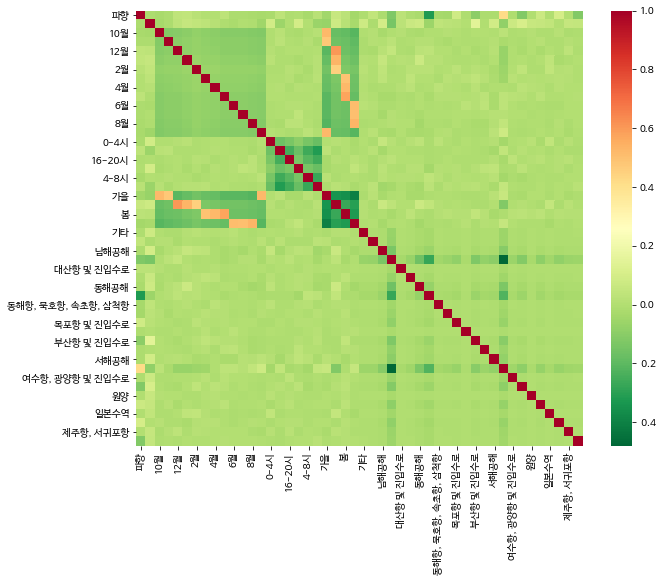

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(),cmap='RdYlGn_r')
plt.show()

## 모델링

In [ ]:
### train / test 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
stf = StratifiedKFold(n_splits=5,shuffle=True, random_state=0)

In [ ]:
# Modeling step Test differents algorithms 

classifiers = []
classifiers.append(LogisticRegression(random_state = 0))
#classifiers.append(XGBClassifier(random_state=0))
classifiers.append(GradientBoostingClassifier(random_state=0))
classifiers.append(LGBMClassifier(random_state=0))
classifiers.append(RandomForestClassifier(random_state=0))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train,cv=stf,n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["LogisticRegression","GradientBoosting","LigtGBM","RandomForest"]}) # "XGBoost"

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


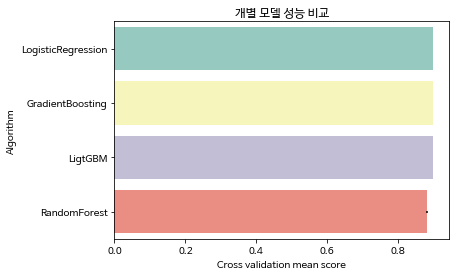

In [ ]:
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Cross validation mean score")
g = g.set_title("개별 모델 성능 비교")

In [ ]:
cv_res.sort_values(by='CrossValMeans',ascending=False) # 로지스틱회귀가 가장 높음

,CrossValMeans,CrossValerrors,Algorithm
0,0.898739,0.000187,LogisticRegression
1,0.898459,0.000374,GradientBoosting
2,0.897805,0.001121,LigtGBM
3,0.881177,0.003050,RandomForest


### 로지스틱 회귀

In [ ]:
### 로지스틱 회귀
lr_model = LogisticRegression(random_state=0)
score = cross_val_score(lr_model, X_train,y_train,cv=stf)
print(score)
print(score.mean())
# 로지스틱회귀 교차검증 결과 정확도 약 89%

[0.89911256 0.89864549 0.89864549 0.89864549 0.89864549]
0.898738907052779


In [ ]:
lr_model.fit(X_train,y_train)
lr_model.score(X_valid,y_valid)
# 로지스틱회귀 test data set에서 정확도 약 90%

0.9032468947483112

In [ ]:
for feature in zip(X_train.columns,lr_model.coef_.reshape(-1,1).tolist()):
  print(feature)

In [ ]:
td = pd.DataFrame({'column':X_train.columns})
td2 = pd.DataFrame(np.exp(lr_model.coef_)).T
td2.columns = ['coef']
codf = pd.concat([td,td2],axis=1)
codf.sort_values('coef',ascending=False)

,column,coef
38,서해공해,2.661761
24,기타,2.165529
42,원양,2.115478
28,대산항 및 진입수로,1.863897
44,일본수역,1.494396
35,"부산거제수역(옥포, 장승포)",1.454711
26,남해공해,1.447655
40,"여수항, 광양항 및 진입수로",1.350433
6,2월,1.305066
39,서해영해,1.304847


### Gradient Boosting

In [ ]:
### GBM
gbm_model = GradientBoostingClassifier(random_state=0)
score = cross_val_score(gbm_model, X_train,y_train,cv=stf)
print(score)
print(score.mean())
# GBM 교차검증 결과 약 89%

[0.89911256 0.89817842 0.89817842 0.89864549 0.89817842]
0.8984586641756188


In [ ]:
gbm_model.fit(X_train,y_train)
gbm_model.score(X_valid,y_valid)
# GBM test data set에서 정확도 약 90%

0.9023752451514491

### XGBoost

In [ ]:
### XGBOOST
xgb_model = XGBClassifier(random_state=0)
score = cross_val_score(xgb_model, X_train,y_train,cv=stf)
print(score)
print(score.mean())
# XGB 교차검증 결과 약 89%

[0.89911256 0.89864549 0.89864549 0.89864549 0.89864549]
0.898738907052779


In [ ]:
xgb_model.fit(X_train,y_train)
xgb_model.score(X_valid,y_valid)
# XGB test data set에서 정확도 약 90%

0.9032468947483112

### Random Forest

In [ ]:
### Random Forest
rf_model = RandomForestClassifier(random_state=0)
score = cross_val_score(rf_model, X_train,y_train,cv=stf)
print(score)
print(score.mean())
# RF 교차검증 결과 약 88.11%

[0.87575899 0.88183092 0.88089678 0.88229799 0.88510042]
0.8811770200840728


In [ ]:
rf_model.fit(X_train,y_train)
rf_model.score(X_valid,y_valid)
# RF test data set에서 정확도 약 88.01%

0.8801481804314666

### Feature importance

Text(0.5, 0, 'Relative Importance')

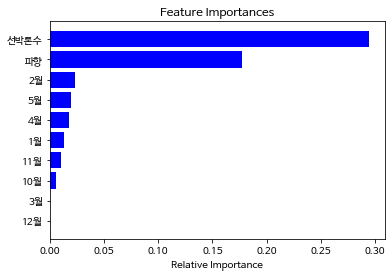

In [ ]:
gbm_model.fit(X_train,y_train)

features = X_train.columns[:10]
importances = gbm_model.feature_importances_[:10]
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')